# Reuters-21578 Multi-label classifier

On this project we are going to build a multi-label classifier using the well known **Reuters-21578** dataset. This dataset contains news from Reuters that were labeled manually using several labels as topics, places, organizations, people and more.  

The dataset contains 21578 news articles in SGML format. We are going to be using only the label **topics** and we are going to classify the text into 3 topics, taking into account that one topic could have more than one label (multi-label).   

## Load and preprocessing of the dataset.

We start by loading the files of the dataset, once loaded we parsed them using a SGML Parser saving the information that follows the following criteria:

* Inside the Tag 'REUTERS' the Attribute 'TOPICS' has the value 'YES' or 'NO'.
* There must be at least one topic in the Tag 'TOPICS'.
* The Tag 'BODY' is non empty.

Once we get these information, the next step is to remove the parts that aren't useful for us, like numbers and symbols.

The final step here will be to vectorize the data (without including stopwords). We will try two different vectorizers.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sgmllib import SGMLParser

# SGML Parser
class reutersParser(SGMLParser):
    def __init__(self, encoding='latin-1'):
        SGMLParser.__init__(self)
        self.encoding = encoding
        self.bodyflag = 0
        self.reutersflag = 0
        self.topicsflag = 0
        self.dflag = 0
        self.titleflag = 0
        self.lista = []
        self.tags = []
        self.new_id = 0
        self.body = ""
        self.title = ""
        
    def reset(self):
        SGMLParser.reset(self)
        self.bodyflag = 0
        self.reutersflag = 0
        self.topicsflag = 0
        self.dflag = 0
        self.titleflag = 0
        self.lista = []
        self.tags = []
        self.new_id = 0
        self.body = ""
        self.title = ""
        
    def start_reuters(self, attr):
        tpc = [v for k, v in attr if k == 'topics']
        if tpc and (tpc[0] == 'YES' or tpc[0] == 'NO'):
            self.reutersflag = 1
        id = [v for k, v in attr if k == 'newid']
        if id:
            self.new_id = id[0]
                
    def start_topics(self, attr):
        self.topicsflag = 1
    
    def start_d(self, attr):
        if self.reutersflag == 1 and self.topicsflag == 1:
            self.dflag = 1
    
    def start_title(self, attr):
        self.titleflag = 1
                
    def start_body(self, attr):
        self.bodyflag = 1
    
    def end_topics(self):
        self.topicsflag = 0
        
    def end_body(self):
        self.bodyflag = 0
        
    def end_reuters(self):
        self.reutersflag = 0
        if self.tags and self.body != "" and self.new_id != 0:
            self.lista.append((self.new_id, self.title, ', '.join(self.tags), self.body))
        self.tags = []
        self.body = ""
        self.new_id = 0
        self.title = 0
    
    def handle_data(self, text):
        if self.bodyflag == 1:
            self.body = text
            self.bodyflag = 0
        if self.dflag == 1:
            self.tags.append(text)
            self.dflag = 0
        if self.titleflag == 1:
            self.title = text
            self.titleflag = 0
            
    def print_lista(self):
        print(self.lista)


# Function to get the data of the parser as a list. 
def parse_reuters_data(data):
    rparser = reutersParser()
    rparser.feed(data.decode(rparser.encoding))
    rparser.close()
    return rparser.lista



In [3]:
import os.path
import re
import tarfile
from glob import glob
from sklearn.externals.six.moves import urllib
from sklearn.datasets import get_data_home

# Function to get the files from the dataset.
def fetch_reuters_documents(data_path=None, verbose=False):
    """
    Obtener todos los documentos del dataset de Reuters con sus respectivos topics.

    Si el directorio `data_path` no existe, se descarga del sitio oficial y descomprime el archivo en ese directorio.
    Por defecto el data_path es `os.path.join(get_data_home(), 'reuters')`.
    La URL oficial del dataset es 'https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.tar.gz'.
    """

    DOWNLOAD_URL = ('https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
        
    if not os.path.exists(data_path):
        print('Descargando el dataset de Reuters...\n')
        
        # Create the directory for the files.
        os.mkdir(data_path)
        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        
        # Download the compressed file.
        urllib.request.urlretrieve(DOWNLOAD_URL, filename=archive_path)
            
        # Decompress it.
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
    
    files = []
    for filename in glob(os.path.join(data_path, "*.sgm")):
        files.append(filename)

    return files


In [4]:
# Get the files from the dataset Reuters-21578.
files = fetch_reuters_documents()

# We Parse the files and create a DataFrame with the columns 'New_id', 'Title','Topics', 'Body'.

# Parse the first file.
file = open(files[0])
data = file.read()
data = data.replace('&lt', ' ')

l = parse_reuters_data(data)
df = pd.DataFrame(l, columns=['New_id', 'Title', 'Topics', 'Body'])
file.close()
files.pop(0)

# Parse the rest of the files.
for f in files:
    file = open(f)
    data = file.read()
    data = data.replace('&lt', ' ')
    
    l = parse_reuters_data(data)
    df2 = pd.DataFrame(l, columns=['New_id', 'Title', 'Topics', 'Body'])
    
    frames = [df, df2]
    df = pd.concat(frames, ignore_index=True)
    file.close()

# df is the DataFrame that contains all the documents.
    
# Get all the posible values of 'Topics'
topics = df.Topics.get_values()
# Create a list where each element represents a distinct topic.
new_topics = []
for topic in topics:
    new_topics.extend(topic.split(','))
# Strip spaces before and after a topic.
topics2 = []
for topic in new_topics:
    topics2.append(topic.strip())
    
topics2 = pd.unique(topics2)

# Create binary columns for each topic and add them to the DataFrame df.
for topic in topics2:
    col = np.zeros(df.shape[0])
    for index, row in df.iterrows():
        if topic in row['Topics']:
            col[index] = 1
    df[topic] = col
        

print('dimensiones del DataFrame --> '+ str(df.shape))

# Calculate the 3 topic with most occurences.
sum = df.sum(axis=0)
sum = sum.drop(['New_id', 'Title', 'Topics', 'Body'])
    
primer = sum.idxmax()
primer_cant = sum.max() 

sum = sum.drop(primer)
segundo = sum.idxmax()
segundo_cant = sum.max()

sum = sum.drop(segundo)
tercer = sum.idxmax()
tercer_cant = sum.max()

print('1 - '+ str(primer) + ' con ' + str(primer_cant))
print('2 - '+ str(segundo) + ' con ' + str(segundo_cant))
print('3 - '+ str(tercer) + ' con ' + str(tercer_cant))

dimensiones del DataFrame --> (10377, 123)
1 - earn con 3776.0
2 - acq con 2210.0
3 - money-fx con 684.0


In [5]:
df.Body = df.Body.str.replace("\n", " ")
df.Body = df.Body.str.lower()
df.Body = df.Body.str.replace(">", " ")
df.Body = df.Body.str.replace("0", " ")
df.Body = df.Body.str.replace("1", " ")
df.Body = df.Body.str.replace("2", " ")
df.Body = df.Body.str.replace("3", " ")
df.Body = df.Body.str.replace("4", " ")
df.Body = df.Body.str.replace("5", " ")
df.Body = df.Body.str.replace("6", " ")
df.Body = df.Body.str.replace("7", " ")
df.Body = df.Body.str.replace("8", " ")
df.Body = df.Body.str.replace("9", " ")

df.Title = df.Title.str.lower()
df.Title = df.Title.str.replace("&lt", " ")
df.Title = df.Title.str.replace(">", " ")
df.Title = df.Title.str.replace("0", " ")
df.Title = df.Title.str.replace("1", " ")
df.Title = df.Title.str.replace("2", " ")
df.Title = df.Title.str.replace("3", " ")
df.Title = df.Title.str.replace("4", " ")
df.Title = df.Title.str.replace("5", " ")
df.Title = df.Title.str.replace("6", " ")
df.Title = df.Title.str.replace("7", " ")
df.Title = df.Title.str.replace("8", " ")
df.Title = df.Title.str.replace("9", " ")

df.head()

,New_id,Title,Topics,Body,earn,wheat,corn,soybean,grain,oilseed,...,nzdlr,castorseed,rupiah,cottonseed,bfr,cpu,peseta,skr,dkr,ringgit
0,12001,republic savings and loan ;rsla sets dividend,earn,qtly div cts vs cts prior pay april ...,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12002,shultz ussr trip fuels talk of eep wheat offer,"wheat, corn, soybean, grain, oilseed",speculation the united states will offer subsi...,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12003,kaines confirms white sugar sales to india,sugar,london-based sugar operator kaines ltd confirm...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12005,;thl holdings inc year jan net,earn,oper net . mln vs . mln revs . bil...,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12007,mountain states adds two minerals properties,"acq, strategic-metal",mountain states resources corp said it acquire...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We'll use two different vectorizers, **CountVectorizer** y **TfidfVectorizer**. With each of them we generate 3 different "corpus" to work with. These are:

* **X_tf_b** uses the *tfidf* vectorization of the text from the Tag 'BODY'.
* **X_tf_t** uses the *tfidf* vectorization of the text from the Tag 'TITLE'.
* **X_tf_tb** uses the *tfidf* vectorization of the concatenation from the Tag 'BODY' and the Tag 'TITLE'.

* **X_c_b** uses the *count* vectorization of the text from the Tag 'BODY'.
* **X_c_t** uses the *count* vectorization of the text from the Tag 'TITLE'.
* **X_c_tb** uses the *count* vectorization of the concatenation from the Tag 'BODY' and the Tag 'TITLE'.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

# Function that returns a list of words with their respective frequencies.
# The list is sorted by frequency (great > less).
def palabras_mas_frecuentes(vectorizer, X):
    terms = vectorizer.get_feature_names()
    freqs = X.sum(axis=0).A1
    result = dict(zip(terms, freqs))
    sorted_res = sorted(result.items(), key=operator.itemgetter(1))
    sorted_res.reverse()
    return sorted_res


vectorizer_tf = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', encoding='latin-1')

# Tfidf vectors with the words from the 'body' of the documents.
X_tf_b = vectorizer_tf.fit_transform(df.Body.values)

# Tfidf vectors with the words from the 'title' of the documents.
X_tf_t = vectorizer_tf.fit_transform(df.Title.values)

# Tfidf vectors with the words from the 'body' and 'title' of the documents.
X_tf_tb = vectorizer_tf.fit_transform(df.Title.values + ' ' + df.Body.values)

vectorizer_c = CountVectorizer(min_df=1, stop_words='english', encoding='latin-1')

# Count vectors with the words from the 'body' of the documents. 
X_c_b = vectorizer_c.fit_transform(df.Body.values)

# Count vectors with the words from the 'title' of the documents.
X_c_t = vectorizer_c.fit_transform(df.Title.values)

# Count vectors with the words from the 'body' and 'title' of the documents.
X_c_tb = vectorizer_c.fit_transform(df.Title.values + ' ' + df.Body.values)


In [7]:
# Print for each of the vector-sets Tfidf the 5th most frequent words.
arrays_b = [['body', 'body'],
          ['Palabra', 'Frecuencia']]
tuples_b = list(zip(*arrays_b))
index_b = pd.MultiIndex.from_tuples(tuples_b)
df_frec_tf_b = pd.DataFrame(palabras_mas_frecuentes(vectorizer_tf, X_tf_b), columns=index_b)

arrays_t = [['title', 'title'],
           ['Palabra', 'Frecuencia']]
tuples_t = list(zip(*arrays_t))
index_t = pd.MultiIndex.from_tuples(tuples_t)
df_frec_tf_t = pd.DataFrame(palabras_mas_frecuentes(vectorizer_tf, X_tf_t), columns=index_t)

arrays_tb = [['title+body', 'title+body'],
            ['Palabra', 'Frecuencia']]
tuples_tb = list(zip(*arrays_tb))
index_tb = pd.MultiIndex.from_tuples(tuples_tb)
df_frec_tf_tb = pd.DataFrame(palabras_mas_frecuentes(vectorizer_tf, X_tf_tb), columns=index_tb)


df_frec = pd.concat([df_frec_tf_b, df_frec_tf_t, df_frec_tf_tb], axis=1)
df_frec.head(5)

body                 title             title+body            
              Palabra  Frecuencia   Palabra  Frecuencia    Palabra  Frecuencia
0              stocks  913.451414   distort  322.613903         vs  656.056888
1            consents  737.315058   cutback  287.730785        cts  519.735991
2  lebensversicherung  610.606894  bankeast  185.401076        mln  497.989532
3            lyonnais  500.539743     fared  161.076298        net  448.661623
4                rcbi  487.168723   fueling  131.796938        shr  357.457768

In [8]:
# Print for each of the vector-sets the 5th most frequent words.
arrays_b = [['body', 'body'],
          ['Palabra', 'Ocurrencias']]
tuples_b = list(zip(*arrays_b))
index_b = pd.MultiIndex.from_tuples(tuples_b)
df_frec_c_b = pd.DataFrame(palabras_mas_frecuentes(vectorizer_c, X_c_b), columns=index_b)

arrays_t = [['title', 'title'],
           ['Palabra', 'Ocurrencias']]
tuples_t = list(zip(*arrays_t))
index_t = pd.MultiIndex.from_tuples(tuples_t)
df_frec_c_t = pd.DataFrame(palabras_mas_frecuentes(vectorizer_c, X_c_t), columns=index_t)

arrays_tb = [['title+body', 'title+body'],
            ['Palabra', 'Ocurrencias']]
tuples_tb = list(zip(*arrays_tb))
index_tb = pd.MultiIndex.from_tuples(tuples_tb)
df_frec_c_tb = pd.DataFrame(palabras_mas_frecuentes(vectorizer_c, X_c_tb), columns=index_tb)


df_frec = pd.concat([df_frec_c_b, df_frec_c_t, df_frec_c_tb], axis=1)
df_frec.head(5)

body                  title             title+body  \
              Palabra Ocurrencias    Palabra Ocurrencias    Palabra   
0            prevents     27314.0    distort      1869.0       said   
1  lebensversicherung     18473.0    cutback      1518.0        mln   
2              stocks     14170.0   bankeast       823.0         vs   
3           defintive     12408.0      fared       675.0       dlrs   
4                play     10325.0  docklands       512.0     reuter   

               
  Ocurrencias  
0       27366  
1       18697  
2       14170  
3       12506  
4       10326

## Classification

Now that we have our data ready, we can begin with the classification stage. Since we are going to be classifying documents that could have one to three topics, we could tackle this as if it were three different binary classification problems. Because of that, we are going to use a **OneVsRestClassifier**.   

We will be using cross-validation of size ten to calculate the performance of the different classifiers. This will help to mitigate overfitting the training set.

We are going to use the six corpus defined in the first section.

In [9]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer

# Create a DataFrame with the columns 'earn', 'acq' and 'money-fx'
df_targets = df[['earn', 'acq', 'money-fx']].copy()

# Create an array for the target values.
targets = []
for index, row in df_targets.iterrows():
    targets.append(dict([('earn', row['earn']), ('acq', row['acq']), ('money-fx', row['money-fx'])]))


# Create the target values matrix.
ml_target = []
for i in range(0, len(targets)):
    aux = []
    if targets[i]['earn'] == 1:
        aux.append(0)
    if targets[i]['acq'] == 1:
        aux.append(1)
    if targets[i]['money-fx'] == 1:
        aux.append(2)
    ml_target.append(aux)

# Create from the target value matrix a binarized version of it,
# this version will be used by the multilabel classifier.
mlb = MultiLabelBinarizer()
multi_label = mlb.fit_transform(ml_target)

In [10]:
# Function to get the performance of a classifier 'clf' using cross-validation of size 'cv'.
# 'X' corresponds to the vectorized documents and 'y_ml' is the target values in multilabel format.
def performance_multi_label(clf, X, y_ml, cv):
    clf_name = clf.__class__.__name__
    precision = cross_val_score(OneVsRestClassifier(clf), X, y_ml, cv=cv, scoring="precision_weighted")
    precision_str = "%0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2)
    
    f1 = cross_val_score(OneVsRestClassifier(clf), X, y_ml, cv=cv, scoring="f1_weighted")
    f1_str = "%0.2f (+/- %0.2f)" % (f1.mean(), f1.std() * 2)
    
    recall = cross_val_score(OneVsRestClassifier(clf), X, y_ml, cv=cv, scoring="recall_weighted")
    recall_str = "%0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2)
    
    accuracy = cross_val_score(OneVsRestClassifier(clf), X, y_ml, cv=cv, scoring="accuracy")
    accuracy_str = "%0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2)
    
    return clf_name, precision_str, f1_str, recall_str, accuracy_str

# Define the columns of the DataFrame used to show the performance metrics.
cols_df_per = ['Clasificador', 'Precision', 'F1', 'Recall', 'Accuracy']


In [11]:
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

clasificadores = [MultinomialNB(alpha=.05),
                  SGDClassifier(alpha=1e-3, n_iter=5, shuffle=True, random_state=42),
                  Perceptron(n_iter=50),
                  PassiveAggressiveClassifier(n_iter=50),
                  RidgeClassifier(tol=1e-2, solver="lsqr"),
                  SVC(kernel='linear')
                  ]

# Calculate the performance of different classifiers using the Tfidf-body vectors.
performance = []
for clf in clasificadores:
    (clf_name, p, f, r, a) = performance_multi_label(clf, X_tf_b, multi_label, 10)
    performance.append((clf_name, p, f, r, a))

df_tf_b = pd.DataFrame(performance, columns=cols_df_per)
df_tf_b

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/ridge.py:299: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


,Clasificador,Precision,F1,Recall,Accuracy
0,MultinomialNB,0.92 (+/- 0.03),0.92 (+/- 0.02),0.92 (+/- 0.04),0.91 (+/- 0.03)
1,SGDClassifier,0.97 (+/- 0.02),0.92 (+/- 0.02),0.88 (+/- 0.03),0.91 (+/- 0.02)
2,Perceptron,0.95 (+/- 0.03),0.95 (+/- 0.02),0.94 (+/- 0.02),0.94 (+/- 0.02)
3,PassiveAggressiveClassifier,0.96 (+/- 0.03),0.95 (+/- 0.02),0.95 (+/- 0.01),0.95 (+/- 0.01)
4,RidgeClassifier,0.97 (+/- 0.02),0.95 (+/- 0.02),0.93 (+/- 0.03),0.94 (+/- 0.02)
5,SVC,0.97 (+/- 0.02),0.96 (+/- 0.01),0.95 (+/- 0.02),0.95 (+/- 0.01)


In [12]:
# Calculate the performance of different classifiers using the Tfidf-title vectors.
performance = []
for clf in clasificadores:
    (clf_name, p, f, r, a) = performance_multi_label(clf, X_tf_t, multi_label, 10)
    performance.append((clf_name, p, f, r, a))

df_tf_t = pd.DataFrame(performance, columns=cols_df_per)
df_tf_t

,Clasificador,Precision,F1,Recall,Accuracy
0,MultinomialNB,0.87 (+/- 0.06),0.86 (+/- 0.06),0.85 (+/- 0.05),0.86 (+/- 0.03)
1,SGDClassifier,0.98 (+/- 0.01),0.81 (+/- 0.05),0.71 (+/- 0.07),0.81 (+/- 0.03)
2,Perceptron,0.92 (+/- 0.05),0.91 (+/- 0.04),0.90 (+/- 0.03),0.90 (+/- 0.03)
3,PassiveAggressiveClassifier,0.94 (+/- 0.04),0.92 (+/- 0.03),0.90 (+/- 0.03),0.91 (+/- 0.02)
4,RidgeClassifier,0.97 (+/- 0.03),0.92 (+/- 0.03),0.87 (+/- 0.03),0.91 (+/- 0.02)
5,SVC,0.97 (+/- 0.03),0.92 (+/- 0.03),0.89 (+/- 0.03),0.92 (+/- 0.02)


In [13]:
# Calculate the performance of different classifiers using the Tfidf-title+body vectors.
performance = []
for clf in clasificadores:
    (clf_name, p, f, r, a) = performance_multi_label(clf, X_tf_tb, multi_label, 10)
    performance.append((clf_name, p, f, r, a))

df_tf_tb = pd.DataFrame(performance, columns=cols_df_per)
df_tf_tb

,Clasificador,Precision,F1,Recall,Accuracy
0,MultinomialNB,0.92 (+/- 0.04),0.92 (+/- 0.03),0.92 (+/- 0.04),0.90 (+/- 0.03)
1,SGDClassifier,0.98 (+/- 0.02),0.93 (+/- 0.02),0.89 (+/- 0.03),0.92 (+/- 0.02)
2,Perceptron,0.95 (+/- 0.03),0.95 (+/- 0.01),0.95 (+/- 0.02),0.94 (+/- 0.01)
3,PassiveAggressiveClassifier,0.97 (+/- 0.02),0.96 (+/- 0.01),0.96 (+/- 0.02),0.95 (+/- 0.01)
4,RidgeClassifier,0.97 (+/- 0.02),0.95 (+/- 0.02),0.94 (+/- 0.02),0.95 (+/- 0.01)
5,SVC,0.97 (+/- 0.02),0.96 (+/- 0.02),0.95 (+/- 0.02),0.96 (+/- 0.01)


In [14]:
# Calculate the performance of different classifiers using the Count-body vectors.
performance = []
for clf in clasificadores:
    (clf_name, p, f, r, a) = performance_multi_label(clf, X_c_b, multi_label, 10)
    performance.append((clf_name, p, f, r, a))

df_c_b = pd.DataFrame(performance, columns=cols_df_per)
df_c_b

,Clasificador,Precision,F1,Recall,Accuracy
0,MultinomialNB,0.87 (+/- 0.04),0.91 (+/- 0.03),0.95 (+/- 0.03),0.88 (+/- 0.03)
1,SGDClassifier,0.96 (+/- 0.03),0.95 (+/- 0.01),0.94 (+/- 0.01),0.94 (+/- 0.01)
2,Perceptron,0.95 (+/- 0.04),0.94 (+/- 0.02),0.94 (+/- 0.02),0.93 (+/- 0.02)
3,PassiveAggressiveClassifier,0.95 (+/- 0.03),0.95 (+/- 0.02),0.94 (+/- 0.02),0.94 (+/- 0.01)
4,RidgeClassifier,0.96 (+/- 0.03),0.88 (+/- 0.02),0.83 (+/- 0.04),0.87 (+/- 0.02)
5,SVC,0.95 (+/- 0.03),0.95 (+/- 0.02),0.95 (+/- 0.01),0.94 (+/- 0.01)


In [15]:
# Calculate the performance of different classifiers using the Count-title vectors.
performance = []
for clf in clasificadores:
    (clf_name, p, f, r, a) = performance_multi_label(clf, X_c_t, multi_label, 10)
    performance.append((clf_name, p, f, r, a))

df_c_t = pd.DataFrame(performance, columns=cols_df_per)
df_c_t

,Clasificador,Precision,F1,Recall,Accuracy
0,MultinomialNB,0.87 (+/- 0.07),0.88 (+/- 0.05),0.91 (+/- 0.03),0.86 (+/- 0.03)
1,SGDClassifier,0.97 (+/- 0.03),0.91 (+/- 0.03),0.86 (+/- 0.03),0.90 (+/- 0.02)
2,Perceptron,0.91 (+/- 0.05),0.91 (+/- 0.03),0.91 (+/- 0.03),0.90 (+/- 0.02)
3,PassiveAggressiveClassifier,0.93 (+/- 0.04),0.92 (+/- 0.03),0.91 (+/- 0.02),0.91 (+/- 0.02)
4,RidgeClassifier,0.96 (+/- 0.04),0.92 (+/- 0.03),0.89 (+/- 0.03),0.91 (+/- 0.02)
5,SVC,0.95 (+/- 0.04),0.93 (+/- 0.03),0.91 (+/- 0.02),0.92 (+/- 0.02)


In [16]:
# Calculate the performance of different classifiers using the Count-title+body vectors.
performance = []
for clf in clasificadores:
    (clf_name, p, f, r, a) = performance_multi_label(clf, X_c_tb, multi_label, 10)
    performance.append((clf_name, p, f, r, a))

df_c_tb = pd.DataFrame(performance, columns=cols_df_per)
df_c_tb

,Clasificador,Precision,F1,Recall,Accuracy
0,MultinomialNB,0.87 (+/- 0.05),0.91 (+/- 0.03),0.95 (+/- 0.02),0.87 (+/- 0.03)
1,SGDClassifier,0.96 (+/- 0.02),0.95 (+/- 0.02),0.94 (+/- 0.03),0.94 (+/- 0.01)
2,Perceptron,0.96 (+/- 0.03),0.95 (+/- 0.02),0.94 (+/- 0.02),0.94 (+/- 0.02)
3,PassiveAggressiveClassifier,0.96 (+/- 0.03),0.96 (+/- 0.01),0.95 (+/- 0.01),0.95 (+/- 0.01)
4,RidgeClassifier,0.96 (+/- 0.03),0.91 (+/- 0.02),0.86 (+/- 0.03),0.90 (+/- 0.02)
5,SVC,0.96 (+/- 0.03),0.95 (+/- 0.01),0.95 (+/- 0.01),0.95 (+/- 0.01)


In [17]:
# Function to get the necessary data to create the plots.
def obtener_datos_para_graficar(clf_name, dfs):

    # Get the precision.
    precision = []
    for df in dfs:
        precision.append(df.loc[df.Clasificador == clf_name].Precision.values[0])
    precision_num = []
    for p in precision:
            precision_num.append(float(p[:4]))
    s_p = pd.Series(precision_num, index=["tf-body", "tf-title", "tf-title+body", "c-body", "c-title", "c-title+body"])

    # Get the F1-score.
    f1 = []
    for df in dfs:
        f1.append(df.loc[df.Clasificador == clf_name].F1.values[0])
    f1_num = []
    for f in f1:
            f1_num.append(float(f[:4]))
    s_f = pd.Series(f1_num, index=["tf-body", "tf-title", "tf-title+body", "c-body", "c-title", "c-title+body"])

    # Get the Recall.
    recall = []
    for df in dfs:
        recall.append(df.loc[df.Clasificador == clf_name].Recall.values[0])
    recall_num = []
    for r in recall:
            recall_num.append(float(r[:4]))
    s_r = pd.Series(recall_num, index=["tf-body", "tf-title", "tf-title+body", "c-body", "c-title", "c-title+body"])

    # Get the Accuracy.
    accuracy = []
    for df in dfs:
        accuracy.append(df.loc[df.Clasificador == clf_name].Accuracy.values[0])
    accuracy_num = []
    for a in accuracy:
            accuracy_num.append(float(a[:4]))
    s_a = pd.Series(accuracy_num, index=["tf-body", "tf-title", "tf-title+body", "c-body", "c-title", "c-title+body"])

    return s_p, s_f, s_r, s_a

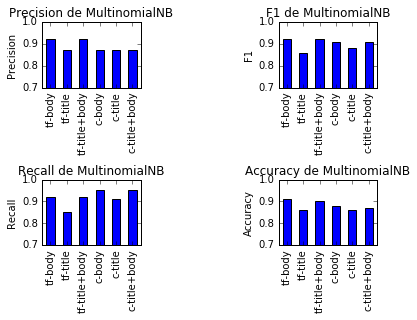

In [18]:
# MultinomialNB plots.
ticks = np.arange(0.7, 1.0, 0.1)

dfs = [df_tf_b, df_tf_t, df_tf_tb, df_c_b, df_c_t, df_c_tb]

s_p_nb, s_f_nb, s_r_nb, s_a_nb = obtener_datos_para_graficar("MultinomialNB", dfs)

p = plt.figure()
ax1 = p.add_subplot(331)
ax1 = s_p_nb.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax1.set_title('Precision de MultinomialNB')
ax1.set_ylabel('Precision')

ax2 = p.add_subplot(333)
ax2 = s_f_nb.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax2.set_title('F1 de MultinomialNB')
ax2.set_ylabel('F1')

ax3 = p.add_subplot(337)
ax3 = s_r_nb.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax3.set_title('Recall de MultinomialNB')
ax3.set_ylabel('Recall')

ax4 = p.add_subplot(339)
ax4 = s_a_nb.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax4.set_title('Accuracy de MultinomialNB')
ax4.set_ylabel('Accuracy')

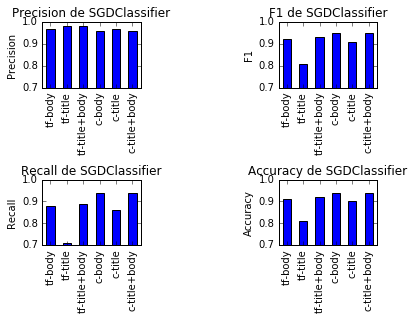

In [19]:
# SGDClassifier plots.
ticks = np.arange(0.7, 1.0, 0.1)

s_p_sgd, s_f_sgd, s_r_sgd, s_a_sgd = obtener_datos_para_graficar("SGDClassifier", dfs)

p = plt.figure()
ax1 = p.add_subplot(331)
ax1 = s_p_sgd.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax1.set_title('Precision de SGDClassifier')
ax1.set_ylabel('Precision')

ax2 = p.add_subplot(333)
ax2 = s_f_sgd.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax2.set_title('F1 de SGDClassifier')
ax2.set_ylabel('F1')

ax3 = p.add_subplot(337)
ax3 = s_r_sgd.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax3.set_title('Recall de SGDClassifier')
ax3.set_ylabel('Recall')

ax4 = p.add_subplot(339)
ax4 = s_a_sgd.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax4.set_title('Accuracy de SGDClassifier')
ax4.set_ylabel('Accuracy')

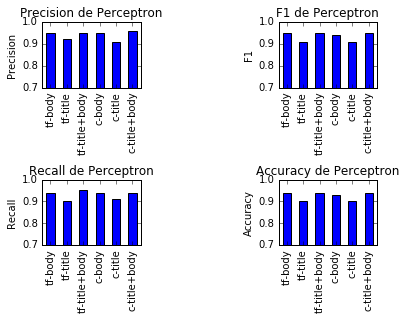

In [20]:
# Perceptron plots.
ticks = np.arange(0.7, 1.0, 0.1)

s_p_ptron, s_f_ptron, s_r_ptron, s_a_ptron = obtener_datos_para_graficar("Perceptron", dfs)

p = plt.figure()
ax1 = p.add_subplot(331)
ax1 = s_p_ptron.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax1.set_title('Precision de Perceptron')
ax1.set_ylabel('Precision')

ax2 = p.add_subplot(333)
ax2 = s_f_ptron.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax2.set_title('F1 de Perceptron')
ax2.set_ylabel('F1')

ax3 = p.add_subplot(337)
ax3 = s_r_ptron.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax3.set_title('Recall de Perceptron')
ax3.set_ylabel('Recall')

ax4 = p.add_subplot(339)
ax4 = s_a_ptron.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax4.set_title('Accuracy de Perceptron')
ax4.set_ylabel('Accuracy')

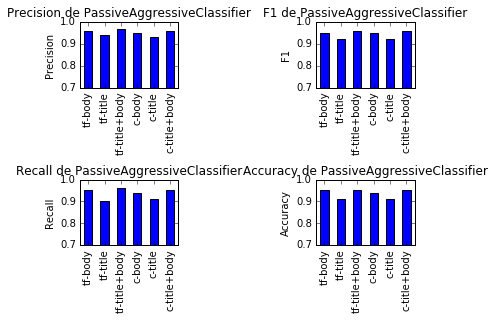

In [21]:
# PassiveAggressiveClassifier plots.
ticks = np.arange(0.7, 1.0, 0.1)

s_p_pac, s_f_pac, s_r_pac, s_a_pac = obtener_datos_para_graficar("PassiveAggressiveClassifier", dfs)

p = plt.figure()
ax1 = p.add_subplot(331)
ax1 = s_p_pac.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax1.set_title('Precision de PassiveAggressiveClassifier')
ax1.set_ylabel('Precision')

ax2 = p.add_subplot(333)
ax2 = s_f_pac.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax2.set_title('F1 de PassiveAggressiveClassifier')
ax2.set_ylabel('F1')

ax3 = p.add_subplot(337)
ax3 = s_r_pac.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax3.set_title('Recall de PassiveAggressiveClassifier')
ax3.set_ylabel('Recall')

ax4 = p.add_subplot(339)
ax4 = s_a_pac.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax4.set_title('Accuracy de PassiveAggressiveClassifier')
ax4.set_ylabel('Accuracy')

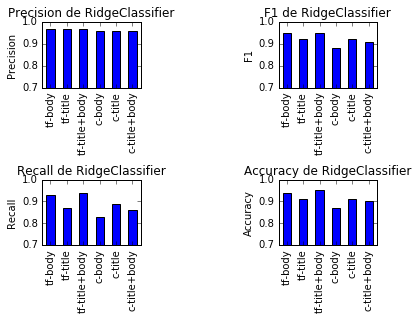

In [22]:
# RidgeClassifier plots.
ticks = np.arange(0.7, 1.0, 0.1)

s_p_rdg, s_f_rdg, s_r_rdg, s_a_rdg = obtener_datos_para_graficar("RidgeClassifier", dfs)

p = plt.figure()
ax1 = p.add_subplot(331)
ax1 = s_p_rdg.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax1.set_title('Precision de RidgeClassifier')
ax1.set_ylabel('Precision')

ax2 = p.add_subplot(333)
ax2 = s_f_rdg.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax2.set_title('F1 de RidgeClassifier')
ax2.set_ylabel('F1')

ax3 = p.add_subplot(337)
ax3 = s_r_rdg.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax3.set_title('Recall de RidgeClassifier')
ax3.set_ylabel('Recall')

ax4 = p.add_subplot(339)
ax4 = s_a_rdg.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax4.set_title('Accuracy de RidgeClassifier')
ax4.set_ylabel('Accuracy')

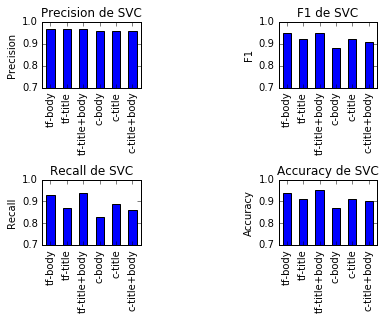

In [23]:
# SVC plots.
ticks = np.arange(0.7, 1.0, 0.1)

s_p_svc, s_f_svc, s_r_svc, s_a_svc = obtener_datos_para_graficar("SVC", dfs)

p = plt.figure()
ax1 = p.add_subplot(331)
ax1 = s_p_rdg.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax1.set_title('Precision de SVC')
ax1.set_ylabel('Precision')

ax2 = p.add_subplot(333)
ax2 = s_f_rdg.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax2.set_title('F1 de SVC')
ax2.set_ylabel('F1')

ax3 = p.add_subplot(337)
ax3 = s_r_rdg.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax3.set_title('Recall de SVC')
ax3.set_ylabel('Recall')

ax4 = p.add_subplot(339)
ax4 = s_a_rdg.plot(kind="bar", yticks=ticks, ylim=(0.7, 1.0))
ax4.set_title('Accuracy de SVC')
ax4.set_ylabel('Accuracy')